#Config

In [ ]:
no_of_class_labels = 2
no_of_rows = 10000
#embeddings
max_words = 40000 #from pretrained model
max_len = 100 #embedding size

#1.Scraping

Unfortunately due to limitations in academic access to twitter api (either 403 or 401 error), I was unable to scrape data myself.
Instead, I am using tweets that are not yet cleaned and not tagged.

In [ ]:
import pandas as pd 

In [ ]:
df = pd.read_csv('Tweets.csv', usecols=['text'])
df = df.head(no_of_rows)

##1B.Remove stopwords and data cleanup

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')

df['pure_text'] = df['text']
df_errors =  df.loc[~df['text'].apply(lambda x: isinstance(x, str))]
print(df_errors)

df['text'] = df['text'].str.lower()
df = df.loc[df['text'].apply(lambda x: isinstance(x, str))]
df['text'] = df['text'].apply(word_tokenize)
#TODO: usuwanie linków
df['text'] = df['text'].apply(lambda words: [re.sub(r'[^\w\s]','',word) for word in words])#usuwanie znaków specjalnych

df['text'] = df['text'].apply(lambda words: [word for word in words if word != '' and word not in stopwords.words('english')])

df['text'] = df['text'].apply(lambda x: x if len(x) > 0 else None)
df.dropna(subset=['text'], inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


    text pure_text
314  NaN       NaN


##1C.Embeddings

Here I use pretrained english model - glove 6B. 
I use embedding vectors that have 100 dimensions.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-05-24 12:41:08--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-24 12:41:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-05-24 12:43:48 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential, Model
from keras import layers

from sklearn.model_selection import train_test_split

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words)

texts = df.text
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=max_len)

Found 12454 unique tokens.


In [ ]:
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [ ]:
word_model = gensim.models.Word2Vec(df['text'], min_count=1) 
word_vectors = word_model.wv
sentence_embeddings = [np.mean([word_vectors[word] for word in sentence if word in word_vectors], axis=0)
                       for sentence in df['text']]
df['embedding'] = sentence_embeddings


In [ ]:
vocab = tokenizer.sequences_to_texts(texts)
vocab_size = len(tokenizer.word_index) + 1 # Add 1 cause 0 index is reserved

rows = []
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
		rows.append({"words":word, "vectors":embedding_vector, "token":i})

##1D.K-means


In [ ]:
from sklearn.cluster import KMeans
data_array = np.vstack(df['embedding'].tolist())

kmeans = KMeans(n_clusters=no_of_class_labels,max_iter=1000,random_state=True, n_init=50)
kmeans.fit(df['embedding'].tolist())
labels = kmeans.labels_
df['cluster'] = labels

In [ ]:
positive_cluster_index = 1
positive_cluster_center = kmeans.cluster_centers_[positive_cluster_index]
negative_cluster_center = kmeans.cluster_centers_[1-positive_cluster_index]

#2. Classic ML


In [ ]:
labels = to_categorical(kmeans.labels_, num_classes=no_of_class_labels)
labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state = 42, stratify=labels)

##Model 1

In [ ]:
!pip install plot_keras_history
from sklearn.metrics import confusion_matrix
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9457 sha256=4b373b26cce7e11edf77529d1b9e46d655c754781057dc3f8160f960e3f623eb
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320501 sha256=06a680957e2223b25398cc45338e4a7f22954cde3b1efcfc057d66283efaff62
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1245500   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,248,898
Trainable params: 2,248,898
Non-trainable params: 0
_________________________________________________________________
None


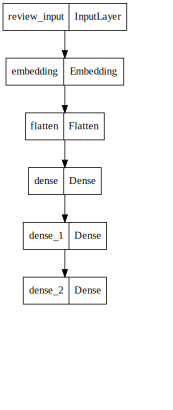

In [ ]:
model1 = Sequential()

model1.add(layers.Input(shape=(max_len,), dtype='int32', name='review_input'))
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=100, activation='relu'))
model1.add(layers.Dense(units=32, activation='relu'))
model1.add(layers.Dense(units=2, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model1.summary())
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [ ]:
history1 = model1.fit(X_train,
                               y_train,
                               epochs=5,
                               batch_size=32,
                               verbose=True,
                               validation_data=(X_test,y_test))

Epoch 1/5
205/205 [==============================] - 11s 48ms/step - loss: 0.5641 - accuracy: 0.7009 - val_loss: 0.4688 - val_accuracy: 0.7668
Epoch 2/5
205/205 [==============================] - 12s 57ms/step - loss: 0.3182 - accuracy: 0.8607 - val_loss: 0.4302 - val_accuracy: 0.8060
Epoch 3/5
205/205 [==============================] - 13s 64ms/step - loss: 0.1406 - accuracy: 0.9490 - val_loss: 0.4402 - val_accuracy: 0.8348
Epoch 4/5
205/205 [==============================] - 12s 59ms/step - loss: 0.0453 - accuracy: 0.9844 - val_loss: 0.6622 - val_accuracy: 0.7956
Epoch 5/5
205/205 [==============================] - 7s 35ms/step - loss: 0.0134 - accuracy: 0.9966 - val_loss: 0.6734 - val_accuracy: 0.8231


In [ ]:
# Get the predicted probabilities for each class
y_pred_probs = model1.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

print(cm)

52/52 [==============================] - 0s 4ms/step
[[619 107]
 [182 726]]


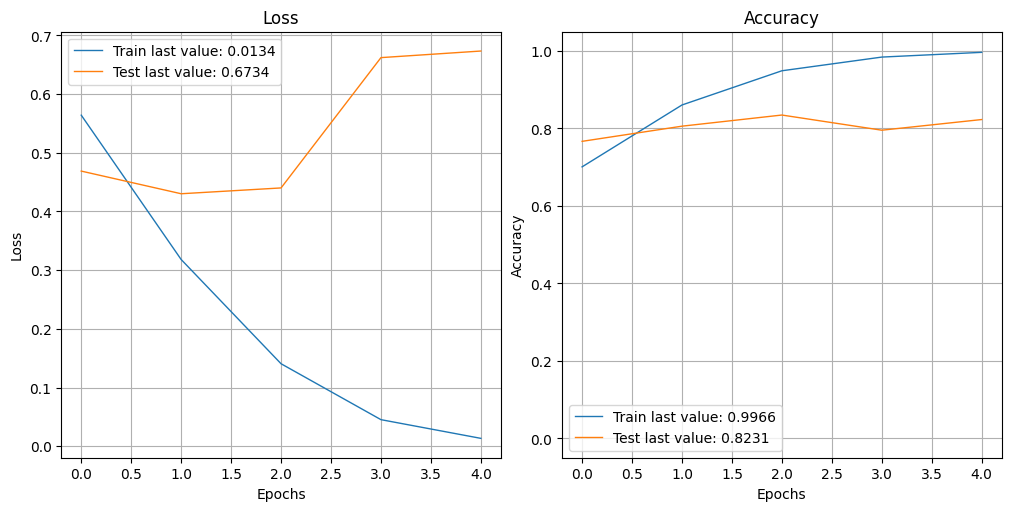

In [ ]:
show_history(history1)
plot_history(history1)
plt.close()

##Model 2

In [ ]:
model2 = Sequential()

model2.add(layers.Input(shape=(max_len,), dtype='int32', name='review_input'))
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model2.add(layers.Flatten())
model2.add(layers.Dense(units=100, activation='relu'))
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(units=64, activation='relu'))
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(units=2, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train,
                               y_train,
                               epochs=5,
                               batch_size=32,
                               verbose=True,
                               validation_data=(X_test,y_test))

Epoch 1/5
205/205 [==============================] - 11s 46ms/step - loss: 0.6391 - accuracy: 0.6244 - val_loss: 0.5358 - val_accuracy: 0.7228
Epoch 2/5
205/205 [==============================] - 12s 58ms/step - loss: 0.4800 - accuracy: 0.7646 - val_loss: 0.4351 - val_accuracy: 0.7840
Epoch 3/5
205/205 [==============================] - 12s 56ms/step - loss: 0.3231 - accuracy: 0.8612 - val_loss: 0.3970 - val_accuracy: 0.8182
Epoch 4/5
205/205 [==============================] - 12s 58ms/step - loss: 0.1957 - accuracy: 0.9224 - val_loss: 0.4929 - val_accuracy: 0.7968
Epoch 5/5
205/205 [==============================] - 6s 29ms/step - loss: 0.1334 - accuracy: 0.9486 - val_loss: 0.4798 - val_accuracy: 0.8256


In [ ]:
# Get the predicted probabilities for each class
y_pred_probs = model2.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

print(cm)

52/52 [==============================] - 0s 4ms/step
[[634  92]
 [193 715]]


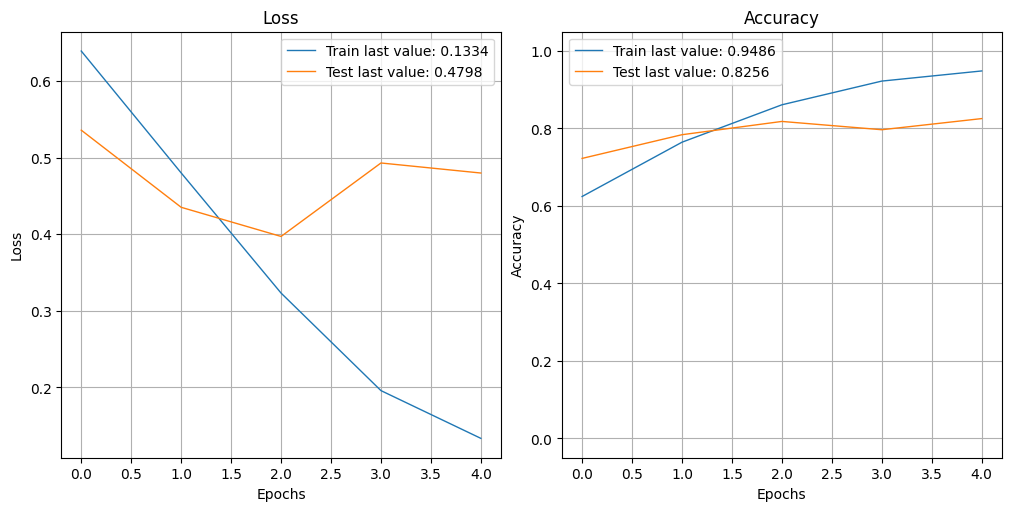

In [ ]:
show_history(history2)
plot_history(history2)
plt.close()

##Model 3

In [ ]:
model3 = Sequential()

model3.add(layers.Input(shape=(max_len,), dtype='int32', name='review_input'))
model3.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
model3.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(units=64, activation='relu'))
model3.add(layers.Dropout(rate=0.5))
model3.add(layers.Dense(units=2, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history3 = model3.fit(X_train,
                               y_train,
                               epochs=5,
                               batch_size=32,
                               verbose=True,
                               validation_data=(X_test,y_test))

Epoch 1/5
205/205 [==============================] - 9s 37ms/step - loss: 0.5788 - accuracy: 0.6991 - val_loss: 0.4551 - val_accuracy: 0.7956
Epoch 2/5
205/205 [==============================] - 8s 39ms/step - loss: 0.3420 - accuracy: 0.8558 - val_loss: 0.3774 - val_accuracy: 0.8299
Epoch 3/5
205/205 [==============================] - 7s 33ms/step - loss: 0.1614 - accuracy: 0.9429 - val_loss: 0.3961 - val_accuracy: 0.8372
Epoch 4/5
205/205 [==============================] - 8s 39ms/step - loss: 0.0639 - accuracy: 0.9800 - val_loss: 0.4569 - val_accuracy: 0.8421
Epoch 5/5
205/205 [==============================] - 7s 32ms/step - loss: 0.0256 - accuracy: 0.9942 - val_loss: 0.5155 - val_accuracy: 0.8384


In [ ]:
# Get the predicted probabilities for each class
y_pred_probs = model3.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

print(cm)

52/52 [==============================] - 0s 4ms/step
[[596 130]
 [134 774]]


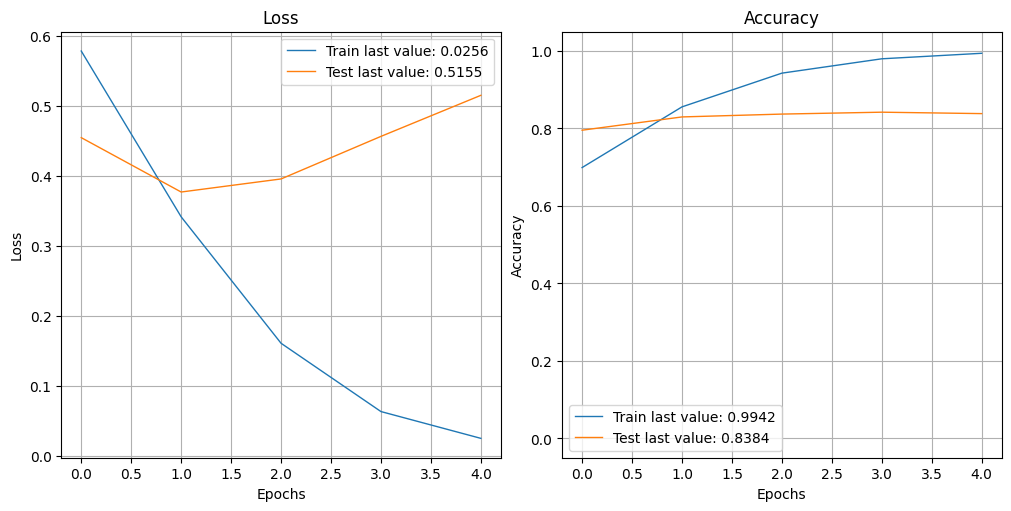

In [ ]:
show_history(history3)
plot_history(history3)
plt.close()

#Step 3

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=0abc1c8a5ef7dabf35c33a99be54594d5fb80fc6a873a264dd03cdce7f5ad41c
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
num_classes=2 
input_dim=max_len

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import wandb

#wandb.init(project='twitter_sentiment')

num_epochs = 5
batch_sizes = [16]
learning_rates = [0.001, 0.1]
num_layers = [1, 2]
dropout_rates = [0.2, 0.5]
activation_functions = ['relu', 'sigmoid']

num_unit = 32

best_model = None;
best_acc = 0;
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_layer in num_layers:
              for dropout_rate in dropout_rates:
                  for activation_function in activation_functions:
                        # Initialize WandB run for each set of parameters
                        wandb.init(project='fine_tuning_project', name=f"experiment_lr_{learning_rate}_nl_{num_layer}_activ_{activation_function}_dropout_{dropout_rate}",)
                        
                        # Set the hyperparameters in the run
                        wandb.config.batch_size = batch_size
                        wandb.config.learning_rate = learning_rate
                        wandb.config.num_layers = num_layer
                        wandb.config.num_units = num_unit
                        wandb.config.dropout_rate = dropout_rate
                        wandb.config.activation_function = activation_function

                        model = Sequential()
                        model.add(layers.Input(shape=(max_len,), dtype='int32', name='review_input'))
                        model.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
                        model.add(layers.Flatten())
                        model.add(Dense(units=num_unit, activation=activation_function, input_shape=(input_dim,)))
                        model.add(Dropout(dropout_rate))
                        for _ in range(num_layer-1):
                            model.add(Dense(units=num_unit, activation=activation_function))
                            model.add(Dropout(dropout_rate))
                        model.add(Dense(units=num_classes, activation='softmax'))
                        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                        model.optimizer.lr.assign(learning_rate)

                        # Train and validate the model
                        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs, verbose=1)
                        val_accuracy = history.history['val_accuracy'][-1]

                        # Log metrics to WandB
                        wandb.log({'val_accuracy': val_accuracy})

                        if (best_model is None):
                          best_model = model
                          best_acc = val_accuracy
                        else:
                          if(val_accuracy>best_acc):
                            best_acc = val_accuracy
                            best_model = model

                        wandb.finish()  # Finish the WandB run

#save model
model.save('part3.model')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/5
409/409 [==============================] - 18s 40ms/step - loss: 0.5560 - accuracy: 0.7086 - val_loss: 0.4679 - val_accuracy: 0.7699
Epoch 2/5
409/409 [==============================] - 18s 45ms/step - loss: 0.3301 - accuracy: 0.8525 - val_loss: 0.4000 - val_accuracy: 0.8127
Epoch 3/5
409/409 [==============================] - 11s 26ms/step - loss: 0.1592 - accuracy: 0.9388 - val_loss: 0.4478 - val_accuracy: 0.8164
Epoch 4/5
409/409 [==============================] - 9s 21ms/step - loss: 0.0689 - accuracy: 0.9766 - val_loss: 0.5082 - val_accuracy: 0.8164
Epoch 5/5
409/409 [==============================] - 10s 24ms/step - loss: 0.0337 - accuracy: 0.9902 - val_loss: 0.5653 - val_accuracy: 0.8213


val_accuracy,▁
val_accuracy,0.8213


wandb: Currently logged in as: msterczewski2. Use `wandb login --relogin` to force relogin


Epoch 1/5
409/409 [==============================] - 10s 22ms/step - loss: 0.5629 - accuracy: 0.6999 - val_loss: 0.4620 - val_accuracy: 0.7821
Epoch 2/5
409/409 [==============================] - 9s 21ms/step - loss: 0.3345 - accuracy: 0.8541 - val_loss: 0.4188 - val_accuracy: 0.8084
Epoch 3/5
409/409 [==============================] - 8s 20ms/step - loss: 0.1741 - accuracy: 0.9373 - val_loss: 0.4030 - val_accuracy: 0.8280
Epoch 4/5
409/409 [==============================] - 9s 23ms/step - loss: 0.0808 - accuracy: 0.9729 - val_loss: 0.4299 - val_accuracy: 0.8348
Epoch 5/5
409/409 [==============================] - 8s 20ms/step - loss: 0.0378 - accuracy: 0.9905 - val_loss: 0.4818 - val_accuracy: 0.8354


val_accuracy,▁
val_accuracy,0.83537


Epoch 1/5
409/409 [==============================] - 15s 32ms/step - loss: 0.5824 - accuracy: 0.6893 - val_loss: 0.4933 - val_accuracy: 0.7674
Epoch 2/5
409/409 [==============================] - 9s 23ms/step - loss: 0.3851 - accuracy: 0.8255 - val_loss: 0.4099 - val_accuracy: 0.8201
Epoch 3/5
409/409 [==============================] - 8s 19ms/step - loss: 0.2311 - accuracy: 0.9048 - val_loss: 0.4092 - val_accuracy: 0.8158
Epoch 4/5
409/409 [==============================] - 10s 23ms/step - loss: 0.1275 - accuracy: 0.9541 - val_loss: 0.4095 - val_accuracy: 0.8335
Epoch 5/5
409/409 [==============================] - 9s 23ms/step - loss: 0.0708 - accuracy: 0.9760 - val_loss: 0.5409 - val_accuracy: 0.8317


val_accuracy,▁
val_accuracy,0.8317


Epoch 1/5
409/409 [==============================] - 10s 23ms/step - loss: 0.5977 - accuracy: 0.6739 - val_loss: 0.4775 - val_accuracy: 0.7821
Epoch 2/5
409/409 [==============================] - 10s 25ms/step - loss: 0.3902 - accuracy: 0.8219 - val_loss: 0.3840 - val_accuracy: 0.8219
Epoch 3/5
409/409 [==============================] - 9s 23ms/step - loss: 0.2208 - accuracy: 0.9131 - val_loss: 0.3650 - val_accuracy: 0.8421
Epoch 4/5
409/409 [==============================] - 9s 21ms/step - loss: 0.1234 - accuracy: 0.9564 - val_loss: 0.3948 - val_accuracy: 0.8421
Epoch 5/5
409/409 [==============================] - 9s 23ms/step - loss: 0.0709 - accuracy: 0.9777 - val_loss: 0.4271 - val_accuracy: 0.8458


val_accuracy,▁
val_accuracy,0.84578


Epoch 1/5
409/409 [==============================] - 10s 22ms/step - loss: 0.5893 - accuracy: 0.6786 - val_loss: 0.4834 - val_accuracy: 0.7687
Epoch 2/5
409/409 [==============================] - 12s 29ms/step - loss: 0.3755 - accuracy: 0.8369 - val_loss: 0.4171 - val_accuracy: 0.8133
Epoch 3/5
409/409 [==============================] - 10s 23ms/step - loss: 0.1958 - accuracy: 0.9256 - val_loss: 0.4300 - val_accuracy: 0.8158
Epoch 4/5
409/409 [==============================] - 9s 22ms/step - loss: 0.0959 - accuracy: 0.9651 - val_loss: 0.4769 - val_accuracy: 0.8311
Epoch 5/5
409/409 [==============================] - 10s 24ms/step - loss: 0.0492 - accuracy: 0.9835 - val_loss: 0.6419 - val_accuracy: 0.8286


val_accuracy,▁
val_accuracy,0.82864


Epoch 1/5
409/409 [==============================] - 11s 24ms/step - loss: 0.6093 - accuracy: 0.6566 - val_loss: 0.4651 - val_accuracy: 0.7907
Epoch 2/5
409/409 [==============================] - 8s 21ms/step - loss: 0.3614 - accuracy: 0.8485 - val_loss: 0.3957 - val_accuracy: 0.8213
Epoch 3/5
409/409 [==============================] - 10s 24ms/step - loss: 0.1884 - accuracy: 0.9273 - val_loss: 0.3722 - val_accuracy: 0.8525
Epoch 4/5
409/409 [==============================] - 10s 24ms/step - loss: 0.0911 - accuracy: 0.9683 - val_loss: 0.4112 - val_accuracy: 0.8605
Epoch 5/5
409/409 [==============================] - 8s 20ms/step - loss: 0.0448 - accuracy: 0.9858 - val_loss: 0.4909 - val_accuracy: 0.8519


val_accuracy,▁
val_accuracy,0.8519


Epoch 1/5
409/409 [==============================] - 10s 22ms/step - loss: 0.6685 - accuracy: 0.5888 - val_loss: 0.5917 - val_accuracy: 0.7222
Epoch 2/5
409/409 [==============================] - 9s 21ms/step - loss: 0.5405 - accuracy: 0.7172 - val_loss: 0.4719 - val_accuracy: 0.7760
Epoch 3/5
409/409 [==============================] - 9s 23ms/step - loss: 0.3933 - accuracy: 0.8263 - val_loss: 0.4593 - val_accuracy: 0.7938
Epoch 4/5
409/409 [==============================] - 8s 20ms/step - loss: 0.2738 - accuracy: 0.8900 - val_loss: 0.4132 - val_accuracy: 0.8182
Epoch 5/5
409/409 [==============================] - 10s 23ms/step - loss: 0.1886 - accuracy: 0.9299 - val_loss: 0.4597 - val_accuracy: 0.8250


val_accuracy,▁
val_accuracy,0.82497


Epoch 1/5
409/409 [==============================] - 9s 20ms/step - loss: 0.7090 - accuracy: 0.5635 - val_loss: 0.5806 - val_accuracy: 0.7619
Epoch 2/5
409/409 [==============================] - 10s 23ms/step - loss: 0.5059 - accuracy: 0.7626 - val_loss: 0.4080 - val_accuracy: 0.8158
Epoch 3/5
409/409 [==============================] - 9s 23ms/step - loss: 0.3082 - accuracy: 0.8774 - val_loss: 0.3890 - val_accuracy: 0.8244
Epoch 4/5
409/409 [==============================] - 9s 22ms/step - loss: 0.1713 - accuracy: 0.9412 - val_loss: 0.3950 - val_accuracy: 0.8494
Epoch 5/5
409/409 [==============================] - 11s 27ms/step - loss: 0.1076 - accuracy: 0.9668 - val_loss: 0.4322 - val_accuracy: 0.8494


val_accuracy,▁
val_accuracy,0.84945


Epoch 1/5
409/409 [==============================] - 11s 24ms/step - loss: 1.6354 - accuracy: 0.5425 - val_loss: 0.6892 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6935 - accuracy: 0.5349 - val_loss: 0.6900 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6936 - accuracy: 0.5448 - val_loss: 0.6874 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 10s 24ms/step - loss: 0.6922 - accuracy: 0.5373 - val_loss: 0.7111 - val_accuracy: 0.5557
Epoch 5/5
409/409 [==============================] - 9s 23ms/step - loss: 0.6901 - accuracy: 0.5453 - val_loss: 0.6971 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 11s 25ms/step - loss: 0.7444 - accuracy: 0.5115 - val_loss: 0.8366 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 9s 23ms/step - loss: 0.7512 - accuracy: 0.5090 - val_loss: 0.7153 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 9s 23ms/step - loss: 0.7467 - accuracy: 0.5150 - val_loss: 0.6920 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 10s 24ms/step - loss: 0.7335 - accuracy: 0.5190 - val_loss: 0.7727 - val_accuracy: 0.4443
Epoch 5/5
409/409 [==============================] - 9s 23ms/step - loss: 0.7468 - accuracy: 0.5144 - val_loss: 0.7001 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 11s 24ms/step - loss: 1.1959 - accuracy: 0.5399 - val_loss: 0.6898 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6948 - accuracy: 0.5285 - val_loss: 0.6872 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 10s 24ms/step - loss: 1.5811 - accuracy: 0.5354 - val_loss: 0.7111 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 9s 23ms/step - loss: 0.6947 - accuracy: 0.5364 - val_loss: 0.6870 - val_accuracy: 0.5557
Epoch 5/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6929 - accuracy: 0.5392 - val_loss: 0.6903 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 11s 25ms/step - loss: 0.8372 - accuracy: 0.5115 - val_loss: 0.7896 - val_accuracy: 0.4443
Epoch 2/5
409/409 [==============================] - 10s 23ms/step - loss: 0.8642 - accuracy: 0.5075 - val_loss: 0.8232 - val_accuracy: 0.4443
Epoch 3/5
409/409 [==============================] - 9s 23ms/step - loss: 0.8319 - accuracy: 0.5129 - val_loss: 0.7172 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 8s 19ms/step - loss: 0.8076 - accuracy: 0.5125 - val_loss: 0.6886 - val_accuracy: 0.5557
Epoch 5/5
409/409 [==============================] - 9s 22ms/step - loss: 0.8278 - accuracy: 0.5081 - val_loss: 0.7083 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 10s 22ms/step - loss: 2.0359 - accuracy: 0.5381 - val_loss: 0.6909 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 9s 23ms/step - loss: 0.6926 - accuracy: 0.5392 - val_loss: 0.6955 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 8s 19ms/step - loss: 0.6903 - accuracy: 0.5404 - val_loss: 0.6890 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 9s 23ms/step - loss: 0.6916 - accuracy: 0.5459 - val_loss: 0.6952 - val_accuracy: 0.4443
Epoch 5/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6941 - accuracy: 0.5386 - val_loss: 0.6890 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 11s 23ms/step - loss: 0.6998 - accuracy: 0.5422 - val_loss: 0.6877 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 8s 20ms/step - loss: 0.6921 - accuracy: 0.5502 - val_loss: 0.6874 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 9s 23ms/step - loss: 0.6911 - accuracy: 0.5442 - val_loss: 0.6871 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 10s 24ms/step - loss: 0.6931 - accuracy: 0.5407 - val_loss: 0.6878 - val_accuracy: 0.5557
Epoch 5/5
409/409 [==============================] - 8s 20ms/step - loss: 0.6914 - accuracy: 0.5389 - val_loss: 0.6875 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 10s 23ms/step - loss: 1.9192 - accuracy: 0.5350 - val_loss: 0.6896 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 8s 20ms/step - loss: 0.6931 - accuracy: 0.5432 - val_loss: 0.6870 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 10s 24ms/step - loss: 0.6935 - accuracy: 0.5407 - val_loss: 0.7148 - val_accuracy: 0.4443
Epoch 4/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6964 - accuracy: 0.5283 - val_loss: 0.6902 - val_accuracy: 0.5557
Epoch 5/5
409/409 [==============================] - 9s 22ms/step - loss: 0.6910 - accuracy: 0.5392 - val_loss: 0.6906 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


Epoch 1/5
409/409 [==============================] - 10s 23ms/step - loss: 0.7089 - accuracy: 0.5404 - val_loss: 0.6869 - val_accuracy: 0.5557
Epoch 2/5
409/409 [==============================] - 10s 24ms/step - loss: 0.6928 - accuracy: 0.5429 - val_loss: 0.6894 - val_accuracy: 0.5557
Epoch 3/5
409/409 [==============================] - 10s 25ms/step - loss: 0.6947 - accuracy: 0.5364 - val_loss: 0.6890 - val_accuracy: 0.5557
Epoch 4/5
409/409 [==============================] - 9s 23ms/step - loss: 0.6921 - accuracy: 0.5427 - val_loss: 0.6873 - val_accuracy: 0.5557
Epoch 5/5
409/409 [==============================] - 10s 24ms/step - loss: 0.6917 - accuracy: 0.5418 - val_loss: 0.6885 - val_accuracy: 0.5557


val_accuracy,▁
val_accuracy,0.55569


#Other

In [ ]:
!pip install accelerate
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:00


In [ ]:
df_for_bert = df.loc[:, ["pure_text", "cluster"]]
df_for_bert.columns = ["text","label"]

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.9 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
ds = Dataset.from_pandas(df_for_bert)
labels = to_categorical(df_for_bert.label,num_classes=2)
dataset = ds.train_test_split(test_size = 0.1)

In [ ]:
from transformers import AutoTokenizer

def process(x):
  return tokenizer(x['text'])

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_ds = dataset['train'].map(process)
test_ds = dataset['test'].map(process)

Map:   0%|          | 0/7351 [00:00<?, ? examples/s]

Map:   0%|          | 0/817 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments , Trainer 

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
args = TrainingArguments('distilbert-base-uncased',evaluation_strategy ='epoch',save_strategy ='epoch',learning_rate=2e-5, per_device_train_batch_size =batch_size, per_device_eval_batch_size =batch_size, num_train_epochs =5, 
                         weight_decay =0.01, load_best_model_at_end = True, metric_for_best_model = 'accuracy')

In [ ]:
from datasets import load_metric
metric = load_metric('glue','sst2')

<ipython-input-43-28217ff5fbfa>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue','sst2')


In [ ]:
import numpy as np
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits,axis = -1)
  return metric.compute(predictions = predictions, references = labels)

In [ ]:
trainer = Trainer(model, args, train_dataset = train_ds, eval_dataset = test_ds, tokenizer = tokenizer, compute_metrics = compute_metrics)

In [ ]:
trainer.evaluate([train_ds[0]])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7514804005622864,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.4798,
 'eval_samples_per_second': 2.084,
 'eval_steps_per_second': 2.084}

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.330368,0.848225
2,0.430100,0.268182,0.886169
3,0.201900,0.332783,0.903305


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.330368,0.848225
2,0.430100,0.268182,0.886169
3,0.201900,0.332783,0.903305
4,0.120000,0.478313,0.899633
5,0.062500,0.549249,0.897185


TrainOutput(global_step=2300, training_loss=0.18193297593489938, metrics={'train_runtime': 8905.9142, 'train_samples_per_second': 4.127, 'train_steps_per_second': 0.258, 'total_flos': 377651099848080.0, 'train_loss': 0.18193297593489938, 'epoch': 5.0})

In [ ]:
model.save_pretrained('part4.model')